In [1]:
import paddle 

X = paddle.rand(shape=[2,5]) 
w = paddle.rand(shape=[5,1]) 
b = paddle.rand(shape=[1,1])
z = paddle.matmul(X, w) + b 
print("Input X:",X)
print("Weight :",w,"\nbias b:",b)
print("Output z:",z)

W0610 19:02:09.584008   232 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 11.8
W0610 19:02:09.585404   232 gpu_resources.cc:164] device: 0, cuDNN Version: 8.9.


Input X: Tensor(shape=[2, 5], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[0.65047359, 0.84825796, 0.33373070, 0.27479059, 0.86931336],
        [0.64321703, 0.52008992, 0.16452432, 0.71413255, 0.72785115]])
Weight : Tensor(shape=[5, 1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[0.31628820],
        [0.02991748],
        [0.51766628],
        [0.04543025],
        [0.89701664]]) 
bias b: Tensor(shape=[1, 1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[0.92447019]])
Output z: Tensor(shape=[2, 1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[2.12061858],
        [1.91397858]])


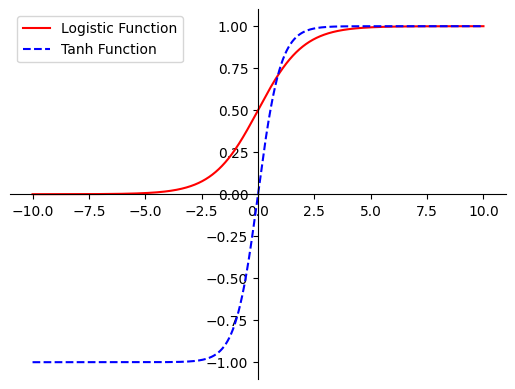

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt 

def logistic(z):
    return 1.0 / (1.0 + paddle.exp(-z))

def tanh(z):
    return (paddle.exp(z) - paddle.exp(-z)) / (paddle.exp(z) + paddle.exp(-z))

z = paddle.linspace(-10, 10, 10000)
plt.figure()
plt.plot(z.tolist(), logistic(z).tolist(), color="red", label="Logistic Function")
plt.plot(z.tolist(), tanh(z).tolist(), color='b', linestyle='--', label="Tanh Function")
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_position(('data',0))
ax.spines['bottom'].set_position(('data',0))
plt.legend()
plt.show()

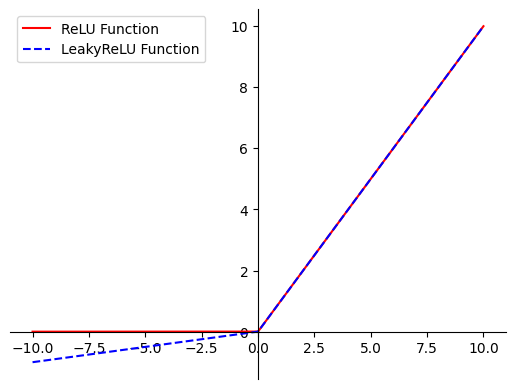

In [3]:
def relu(z):
    return paddle.maximum(z, paddle.to_tensor(0.))

def leaky_relu(z, negative_slope=0.1):
    a1 = (paddle.cast((z>0), dtype='float32')*z)
    a2 = (paddle.cast((z<=0), dtype='float32') * (negative_slope * z))
    return a1+a2

z = paddle.linspace(-10, 10, 10000)
plt.figure()
plt.plot(z.tolist(), relu(z).tolist(), color="red", label="ReLU Function")
plt.plot(z.tolist(), leaky_relu(z).tolist(), color='b', linestyle='--', label="LeakyReLU Function")
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_position(('data',0))
ax.spines['bottom'].set_position(('data',0))
plt.legend()
plt.show()

In [4]:
# 基础算子
class Op(object):
    def __init__(self):
        pass

    def __call__(self, inputs):
        return self.forward(inputs)

    def forward(self, inputs):
        raise NotImplementedError

    def backward(self, inputs):
        raise NotImplementedError

In [5]:
class Linear(Op):
    def __init__(self, input_size, output_size, name, weight_init=paddle.standard_normal, bias_init=paddle.zeros):
        self.params = {}
        self.params['W'] = weight_init(shape=[input_size, output_size])
        self.params['b'] = bias_init(shape=[1, output_size])
        self.inputs = None 
        self.name = name 
    
    def forward(self, inputs):
        outputs = paddle.matmul(inputs, self.params['W']) + self.params['b']
        return outputs

In [6]:
class Logistic(Op):
    def __init__(self):
        self.inputs = None 
        self.outputs = None 
    
    def forward(self, inputs):
        outputs = 1.0 / (1.0 + paddle.exp(-inputs))
        self.outputs = outputs
        return outputs

In [7]:
class Model_MLP_L2(Op):
    def __init__(self, input_size, hidden_size, output_size):
        self.fc1 = Linear(input_size, hidden_size, name="fc1")
        self.act_fn1 = Logistic()
        self.fc2 = Linear(hidden_size, output_size, name="fc2")
        self.act_fn2 = Logistic()

    def __call__(self, X):
        return self.forward(X)

    def forward(self, X):
        z1 = self.fc1(X)
        a1 = self.act_fn1(z1)
        z2 = self.fc2(a1)
        a2 = self.act_fn2(z2)
        return a2

In [8]:
model = Model_MLP_L2(5, 10, 1)
X = paddle.rand(shape=[1,5])
result = model(X)
print(result)

Tensor(shape=[1, 1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[0.02235870]])


In [9]:
class BinaryCrossEntropyLoss(Op):
    def __init__(self, model):
        self.predicts = None 
        self.labels = None 
        self.num = None 
        self.model = model 

    def __call__(self, predicts, labels):
        return self.forward(predicts, labels)

    def forward(self, predicts, labels):
        self.predicts = predicts 
        self.labels = labels 
        self.num = predicts.shape[0]
        loss = -1. / self.num * (paddle.matmul(self.labels.t(), paddle.log(self.predicts)) + paddle.matmul((1-self.labels.t()), paddle.log(1-self.predicts)))
        loss = paddle.squeeze(loss, axis=1)
        return loss 

    def backward(self):
        inputs_grads = -1.0 * (self.labels / self.predicts - (1 - self.labels) / (1 - self.predicts)) / self.num 
        self.model.backward(inputs_grads)

In [10]:
class Logistic(Op):
    def __init__(self):
        self.inputs = None 
        self.outputs = None 
        self.params = None
    
    def forward(self, inputs):
        outputs = 1.0 / (1.0 + paddle.exp(-inputs))
        self.outputs = outputs
        return outputs
    
    def backward(self, outputs_grads):
        outputs_grad_inputs = paddle.multiply(self.outputs, (1.0 - self.outputs))
        return paddle.multiply(outputs_grads, outputs_grad_inputs)

In [11]:
class Linear(Op):
    def __init__(self, input_size, output_size, name, weight_init=paddle.standard_normal, bias_init=paddle.zeros):
        self.params = {}
        self.params['W'] = weight_init(shape=[input_size, output_size])
        self.params['b'] = bias_init(shape=[1, output_size])
        self.inputs = None 
        self.grads = {}
        self.name = name 
    
    def forward(self, inputs):
        self.inputs = inputs
        outputs = paddle.matmul(inputs, self.params['W']) + self.params['b']
        return outputs

    def backward(self, grads):
        self.grads['W'] = paddle.matmul(self.inputs.T, grads)
        self.grads['b'] = paddle.sum(grads, axis=0)
        return paddle.matmul(grads, self.params['W'].T)

In [12]:
class Model_MLP_L2(Op):
    def __init__(self, input_size, hidden_size, output_size):
        self.fc1 = Linear(input_size, hidden_size, name="fc1")
        self.act_fn1 = Logistic()
        self.fc2 = Linear(hidden_size, output_size, name="fc2")
        self.act_fn2 = Logistic()
        self.layers = [self.fc1, self.act_fn1, self.fc2, self.act_fn2]

    def __call__(self, X):
        return self.forward(X)

    def forward(self, X):
        z1 = self.fc1(X)
        a1 = self.act_fn1(z1)
        z2 = self.fc2(a1)
        a2 = self.act_fn2(z2)
        return a2

    def backward(self, loss_grad_a2):
        loss_grad_z2 = self.act_fn2.backward(loss_grad_a2) 
        loss_grad_a1 = self.fc2.backward(loss_grad_z2)
        loss_grad_z1 = self.act_fn1.backward(loss_grad_a1)
        loss_grad_input = self.fc1.backward(loss_grad_z1)

In [13]:
from abc import abstractmethod

#优化器基类
class Optimizer(object):
    def __init__(self, init_lr, model):
        """
        优化器类初始化
        """
        #初始化学习率，用于参数更新的计算
        self.init_lr = init_lr
        #指定优化器需要优化的模型
        self.model = model

    @abstractmethod
    def step(self):
        """
        定义每次迭代如何更新参数
        """
        pass

In [14]:
class BatchGD(Optimizer):
    def __init__(self, init_lr, model):
        super(BatchGD, self).__init__(init_lr=init_lr, model=model)

    def step(self):
        for layer in self.model.layers:
            if isinstance(layer.params, dict):
                for key in layer.params.keys():
                    layer.params[key] = layer.params[key] - self.init_lr * layer.grads[key]


In [15]:
import os 

class RunnerV2_1(object):
    def __init__(self, model, optimizer, metric, loss_fn, **kwargs):
        self.model = model 
        self.optimizer = optimizer 
        self.loss_fn = loss_fn
        self.metric = metric
        self.train_scores = []
        self.dev_scores = []
        self.train_loss = []
        self.dev_loss = []

    def train(self, train_set, dev_set, **kwargs):
        num_epochs = kwargs.get("num_epochs", 0)
        log_epochs = kwargs.get("log_epochs", 100)
        save_dir = kwargs.get("save_dir", None)
        best_score = 0
        for epoch in range(num_epochs):
            X, y = train_set
            logits = self.model(X)
            trn_loss = self.loss_fn(logits, y)
            self.train_loss.append(trn_loss.item())
            trn_score = self.metric(logits, y).item()
            self.train_scores.append(trn_score) 
            self.loss_fn.backward()
            self.optimizer.step()
            dev_score, dev_loss = self.evaluate(dev_set)
            if dev_score > best_score:
                print(f"[Evaluate] best accuracy performance has been updated: {best_score:.5f} --> {dev_score:.5f}")
                best_score = dev_score
                if save_dir:
                    self.save_model(save_dir)

            if log_epochs and epoch % log_epochs == 0:
                print(f"[Train] epoch: {epoch}/{num_epochs}, loss: {trn_loss.item()}")

    def evaluate(self, data_set):
        X, y = data_set
        logits = self.model(X)
        loss = self.loss_fn(logits, y).item()
        self.dev_loss.append(loss)
        score = self.metric(logits, y).item()
        self.dev_scores.append(score)
        return score, loss 

    def predict(self, X):
        return self.model(X)

    def save_model(self, save_dir):
        for layer in self.model.layers:
            if isinstance(layer.params, dict):
                paddle.save(layer.params, os.path.join(save_dir, layer.name+".pdparams")) 

    def load_model(self, model_dir):
        model_file_names = os.listdir(model_dir)
        name_file_dict = {}
        for file_name in model_file_names:
            name = file_name.replace(".pdparams","")
            name_file_dict[name] = os.path.join(model_dir, file_name)
        for layer in self.model.layers:
            if isinstance(layer.params, dict):
                name = layer.name 
                file_path = name_file_dict[name]
                layer.params = paddle.load(file_path)

In [16]:
def accuracy(preds, labels):
    if preds.shape[1] == 1:
        preds = paddle.cast((preds>=0.5), dtype='float32')
    else:
        preds = paddle.argmax(preds, axis=1, dtype='int32')
    return paddle.mean(paddle.cast(paddle.equal(preds, labels), dtype='float32'))

In [17]:
import math
import copy

def make_moons(n_samples=1000, shuffle=True, noise=None):
    n_samples_out = n_samples // 2
    n_samples_in = n_samples - n_samples_out 
    outer_circ_x = paddle.cos(paddle.linspace(0, math.pi, n_samples_out))
    outer_circ_y = paddle.sin(paddle.linspace(0, math.pi, n_samples_out))
    inner_circ_x = 1 - paddle.cos(paddle.linspace(0, math.pi, n_samples_in))
    inner_circ_y = 0.5 - paddle.sin(paddle.linspace(0, math.pi, n_samples_in))
    X = paddle.stack([paddle.concat([outer_circ_x, inner_circ_x]), paddle.concat([outer_circ_y, inner_circ_y])], axis=1) 
    y = paddle.concat([paddle.zeros(shape=[n_samples_out]), paddle.ones(shape=[n_samples_in])])
    if shuffle:
        idx = paddle.randperm(X.shape[0])
        X = X[idx]
        y = y[idx]
    if noise is not None:
        X += paddle.normal(mean=0, std=noise, shape=X.shape)
    return X, y

n_samples = 1000
X, y = make_moons(n_samples=n_samples, shuffle=True, noise=0.5)

In [18]:
num_train = 640
num_dev = 160
num_test = 200

X_train, y_train = X[:num_train], y[:num_train]
X_dev, y_dev = X[num_train:num_train+num_dev], y[num_train:num_train+num_dev]
X_test, y_test = X[num_train+num_dev:], y[num_train+num_dev:]

y_train = y_train.reshape([-1,1])
y_dev = y_dev.reshape([-1,1])
y_test = y_test.reshape([-1,1])

In [19]:
input_size = 2
hidden_size = 5
output_size = 1
model = Model_MLP_L2(input_size, hidden_size, output_size)
loss_fn = BinaryCrossEntropyLoss(model)
lr = 0.2 
optimizer = BatchGD(lr, model)
metric = accuracy 
runner = RunnerV2_1(model, optimizer, metric, loss_fn)
runner.train([X_train, y_train], [X_dev, y_dev], num_epochs=1000, log_epochs=50, save_dir="./checkpoint/model_best.pdparams")

[Evaluate] best accuracy performance has been updated: 0.00000 --> 0.48750
[Train] epoch: 0/1000, loss: 0.9467258453369141
[Evaluate] best accuracy performance has been updated: 0.48750 --> 0.49375
[Evaluate] best accuracy performance has been updated: 0.49375 --> 0.50000
[Evaluate] best accuracy performance has been updated: 0.50000 --> 0.51875
[Evaluate] best accuracy performance has been updated: 0.51875 --> 0.55625
[Evaluate] best accuracy performance has been updated: 0.55625 --> 0.60000
[Evaluate] best accuracy performance has been updated: 0.60000 --> 0.64375
[Evaluate] best accuracy performance has been updated: 0.64375 --> 0.67500
[Evaluate] best accuracy performance has been updated: 0.67500 --> 0.70000
[Evaluate] best accuracy performance has been updated: 0.70000 --> 0.71250
[Evaluate] best accuracy performance has been updated: 0.71250 --> 0.73125
[Evaluate] best accuracy performance has been updated: 0.73125 --> 0.75000
[Evaluate] best accuracy performance has been update

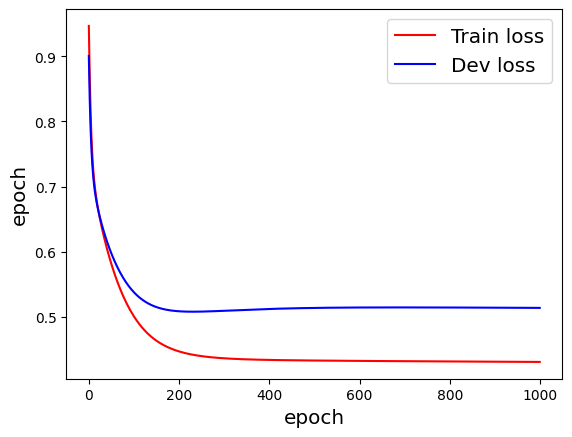

In [20]:
plt.figure()
plt.plot(range(1000), runner.train_loss, color="red", label="Train loss")
plt.plot(range(1000), runner.dev_loss, color="blue", label="Dev loss")
plt.xlabel("epoch", fontsize="x-large")
plt.ylabel("epoch", fontsize="x-large")
plt.legend(fontsize="x-large")
plt.show()

In [21]:
runner.load_model("./checkpoint/model_best.pdparams")
score, loss = runner.evaluate([X_test, y_test])
print("[Test] score/loss {:.4f}/{:.4f}".format(score,loss))

[Test] score/loss 0.8100/0.6289


In [22]:
import paddle.nn as nn 
import paddle.nn.functional as F 
from paddle.nn.initializer import Constant, Normal, Uniform 

class Model_MLP_L2_V2(nn.Layer):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model_MLP_L2_V2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, weight_attr=paddle.ParamAttr(initializer=Normal(mean=0., std=1.)),
        bias_attr=paddle.ParamAttr(initializer=Constant(value=0.0)))
        self.fc2= nn.Linear(hidden_size, output_size, weight_attr=paddle.ParamAttr(initializer=Normal(mean=0., std=1.)),
        bias_attr=paddle.ParamAttr(initializer=Constant(value=0.0)))
        self.act_fn = F.sigmoid

    def forward(self, X):
        z1 = self.fc1(X)
        a1 = self.act_fn(z1)
        z2 = self.fc2(a1)
        a2 = self.act_fn(z2)
        return a2

In [23]:
class RunnerV2_2(object):
    def __init__(self, model, optimizer, metric, loss_fn, **kwargs):
        self.model = model 
        self.optimizer = optimizer 
        self.loss_fn = loss_fn
        self.metric = metric
        self.train_scores = []
        self.dev_scores = []
        self.train_loss = []
        self.dev_loss = []

    def train(self, train_set, dev_set, **kwargs):
        self.model.train()

        num_epochs = kwargs.get("num_epochs", 0)
        log_epochs = kwargs.get("log_epochs", 100)
        save_path = kwargs.get("save_path", "model_best.pdparams")
        custom_print_log = kwargs.get("custom_print_log", None)

        best_score = 0
        for epoch in range(num_epochs):
            X, y = train_set
            logits = self.model(X)
            trn_loss = self.loss_fn(logits, y)
            self.train_loss.append(trn_loss.item())
            trn_score = self.metric(logits, y).item()
            self.train_scores.append(trn_score) 
            trn_loss.backward()
            if custom_print_log is not None:
                custom_print_log(self)
            self.optimizer.step()
            self.optimizer.clear_grad()
            dev_score, dev_loss = self.evaluate(dev_set)
            if dev_score > best_score:
                self.save_model(save_path)
                print(f"[Evaluate] best accuracy performance has been updated: {best_score:.5f} --> {dev_score:.5f}")
                best_score = dev_score

            if log_epochs and epoch % log_epochs == 0:
                print(f"[Train] epoch: {epoch}/{num_epochs}, loss: {trn_loss.item()}")

    @paddle.no_grad()
    def evaluate(self, data_set):
        self.model.eval()
        X, y = data_set
        logits = self.model(X)
        loss = self.loss_fn(logits, y).item()
        self.dev_loss.append(loss)
        score = self.metric(logits, y).item()
        self.dev_scores.append(score)
        return score, loss 

    @paddle.no_grad()
    def predict(self, X):
        model.eval()
        return self.model(X)

    def save_model(self, save_path):
        paddle.save(self.model.state_dict(), save_path) 

    def load_model(self, model_path):
        state_dict = paddle.load(model_path)
        self.model.set_state_dict(state_dict)

In [24]:
input_size = 2
hidden_size = 5
output_size = 1
model = Model_MLP_L2_V2(input_size, hidden_size, output_size)
loss_fn = F.binary_cross_entropy
optimizer = paddle.optimizer.SGD(learning_rate=0.2, parameters=model.parameters())
metric = accuracy 
runner = RunnerV2_2(model, optimizer, metric, loss_fn)
runner.train([X_train, y_train], [X_dev, y_dev], num_epochs=1000, log_epochs=50, save_dir="./checkpoint2/model_best.pdparams")

[Evaluate] best accuracy performance has been updated: 0.00000 --> 0.51250
[Train] epoch: 0/1000, loss: 0.7802160382270813
[Evaluate] best accuracy performance has been updated: 0.51250 --> 0.51875
[Evaluate] best accuracy performance has been updated: 0.51875 --> 0.54375
[Evaluate] best accuracy performance has been updated: 0.54375 --> 0.55000
[Evaluate] best accuracy performance has been updated: 0.55000 --> 0.62500
[Evaluate] best accuracy performance has been updated: 0.62500 --> 0.65625
[Evaluate] best accuracy performance has been updated: 0.65625 --> 0.68750
[Evaluate] best accuracy performance has been updated: 0.68750 --> 0.71250
[Evaluate] best accuracy performance has been updated: 0.71250 --> 0.72500
[Evaluate] best accuracy performance has been updated: 0.72500 --> 0.73750
[Evaluate] best accuracy performance has been updated: 0.73750 --> 0.74375
[Evaluate] best accuracy performance has been updated: 0.74375 --> 0.74375
[Evaluate] best accuracy performance has been update

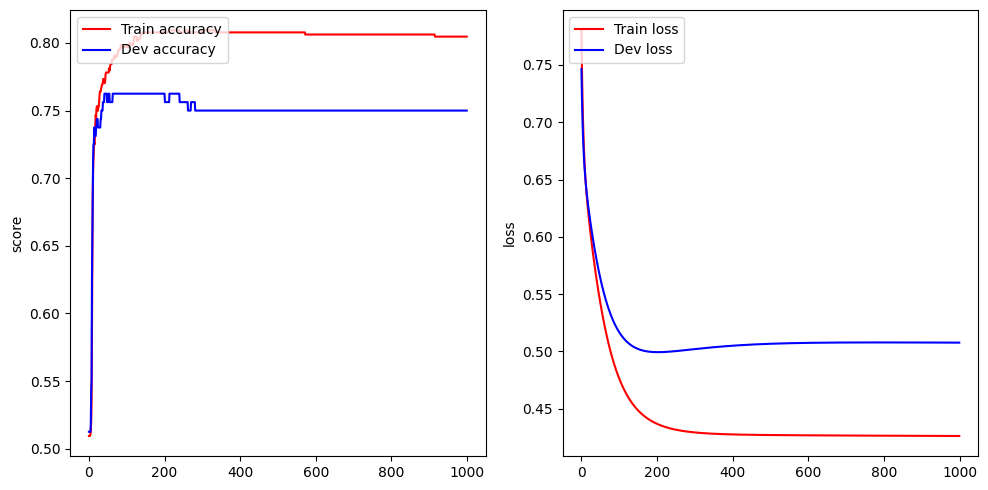

In [25]:
def plot(runner, fig_name):
    plt.figure(figsize=(10,5))
    epochs = [i for i in range(len(runner.train_scores))]
    plt.subplot(1,2,1)
    plt.plot(epochs, runner.train_scores, color="red", label="Train accuracy")
    plt.plot(epochs, runner.dev_scores, color="blue", label="Dev accuracy")
    plt.ylabel("score")
    plt.legend(loc="upper left")
    plt.subplot(1,2,2)
    plt.plot(epochs, runner.train_loss, color="red", label="Train loss")
    plt.plot(epochs, runner.dev_loss, color="blue", label="Dev loss")
    plt.ylabel("loss")
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.savefig(fig_name)
    plt.show()

plot(runner,'fw-acc.pdf')

In [26]:
runner.load_model("./model_best.pdparams")
score, loss = runner.evaluate([X_test, y_test])
print("[Test] score/loss {:.4f}/{:.4f}".format(score,loss))

[Test] score/loss 0.7950/0.5272


In [ ]:
class Model_MLP_L5(nn.Layer):
    def __init__(self, input_size, output_size, act='sigmoid', w_init=Normal(mean=0.1, std=0.01), b_init=Constant(value=1.0)):
        super(Model_MLP_L5, self).__init__()
        self.fc1 = Linear(input_size, 3)
        self.fc2 = Linear(3, 3)
        self.fc3 = Linear(3, 3)
        self.fc4 = Linear(3, 3)
        self.fc5 = Linear(3, output_size)
        if act == 'sigmoid':
            self.act = F.sigmoid
        elif act = 'relu':
            self.act = F.relu 
        elif act = 'lrelu':
            self.act = F.leaky_relu
        else:
            raise ValueError("Please enter sigmoid relu or lrelu")
        self.init_weight(w_init, b_init)

    def __call__(self, X):
        return self.forward(X)

    def forward(self, X):
        z1 = self.fc1(X)
        a1 = self.act_fn1(z1)
        z2 = self.fc2(a1)
        a2 = self.act_fn2(z2)
        return a2

    def backward(self, loss_grad_a2):
        loss_grad_z2 = self.act_fn2.backward(loss_grad_a2) 
        loss_grad_a1 = self.fc2.backward(loss_grad_z2)
        loss_grad_z1 = self.act_fn1.backward(loss_grad_a1)
        loss_grad_input = self.fc1.backward(loss_grad_z1)